In [30]:
import numpy as np
import pandas as pd
from importlib import reload
import pickle

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost
import NeuralNetwork
reload(NeuralNetwork)
from NeuralNetwork import MLPBiomass,BiomassDataset

import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss,init
from torch.optim import AdamW


In [31]:
def get_evaluation(y_true,y_pred):
    '''
        calculate evaluation metrics
    :param y_true: true labels
    :param y_pred: model predictions
    :return: a dictionary containing rmse, average rmse and r2
    '''
    score_dict={}
    score_dict['rmse']=np.round(mean_squared_error(y_true,y_pred,multioutput='raw_values',squared=False),decimals=2)
    score_dict['rmse_ave']=np.round(mean_squared_error(y_true,y_pred,multioutput='uniform_average',squared=False),decimals=2)
    score_dict['r2']=np.round(r2_score(y_true,y_pred),decimals=2)
    return score_dict

def print_evaluation(model_name:str,score_dict:dict):
    '''
        print evaluation information
    :param model_name: 
    :param score_dict: 
    :return: 
    '''
    rmse_list=[]
    column_names=['H2','CO','CO2','CH4','Lower','heating value','Char yield','tar yield']
    for i in range(len(score_dict['rmse'])):
        value_str=score_dict['rmse'][i]
        rmse_list.append(f"{value_str:.2f}\t\t\t{column_names[i]}")
    rmse_str='\n\t\t\t'.join(rmse_list)
    print(f"evaluation of [ {model_name} ]\n\t- average RMSE: {score_dict['rmse_ave']}\n\t- RMSE: \n\t\t\t{rmse_str}\n\t- r2 score: {score_dict['r2']}")

In [32]:
data=pd.read_excel('data/dataBiomass_CE880.xlsx',skiprows=2,header=0).drop('Number',axis=1)
data=data[data['Superficial gas velocity']<8]

x=data.iloc[:,:8]
y=data.iloc[:,8:]

mms_x=MinMaxScaler()
mms_y=MinMaxScaler()
x_norm=mms_x.fit_transform(x)
y_norm=mms_y.fit_transform(y)

x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2)
y_test_denorm=mms_y.inverse_transform(y_test)

In [33]:
# Decision Tree
dtr=DecisionTreeRegressor()
param_grid_dtr={
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10]
}
gs_dtr=GridSearchCV(dtr,param_grid_dtr,scoring='neg_mean_squared_error')
gs_dtr.fit(x_train,y_train)
best_dtr=gs_dtr.best_estimator_
y_pred=best_dtr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
dtr_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Decision Tree',dtr_eval_dict)

evaluation of [ Decision Tree ]
	- average RMSE: 6.94
	- RMSE: 
			4.48			H2
			6.50			CO
			7.20			CO2
			1.82			CH4
			2.33			Lower
			7.17			heating value
			19.10			Char yield
	- r2 score: 0.35


In [34]:
# Raw Random Forest
rfr=RandomForestRegressor()
param_grid_rfr={
    'n_estimators':[100,200],
    'max_depth':[20,40],
}
gs_rfr=GridSearchCV(rfr,param_grid=param_grid_rfr,scoring='neg_mean_squared_error',cv=6)
gs_rfr.fit(x_train,y_train)
# gs_rfr.best_score_
best_rfr=gs_rfr.best_estimator_
y_pred=best_rfr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Random Forest',rfr_eval_dict)

evaluation of [ Random Forest ]
	- average RMSE: 4.53
	- RMSE: 
			3.74			H2
			4.31			CO
			4.22			CO2
			1.74			CH4
			2.06			Lower
			5.79			heating value
			9.85			Char yield
	- r2 score: 0.68


In [35]:
# XGBoost
params = {
    'max_depth': 20,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',  # 多分类问题
    'random_state':None
}
y_pred_total=[]
for i in range(7):
    train_DM=xgboost.DMatrix(data=x_train,label=y_train[:,i])
    test_DM=xgboost.DMatrix(data=x_test,label=y_test[:,i])
    bst=xgboost.train(params,train_DM,num_boost_round=200)
    y_pred=bst.predict(test_DM).reshape(-1,1)
    y_pred_total.append(y_pred)
y_pred=np.concatenate(y_pred_total,axis=1)
y_pred_denorm=mms_y.inverse_transform(y_pred)
xgb_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('XGBoost',xgb_eval_dict)

evaluation of [ XGBoost ]
	- average RMSE: 5.21
	- RMSE: 
			4.97			H2
			4.31			CO
			5.28			CO2
			1.87			CH4
			2.07			Lower
			6.49			heating value
			11.49			Char yield
	- r2 score: 0.6


In [36]:
# Fully-Connected Neural Network
data_train=np.concatenate([x_train,y_train],axis=1)
data_test=np.concatenate([x_test,y_test],axis=1)
tensor_data_train=torch.tensor(data_train,dtype=torch.float32)
tensor_data_test=torch.tensor(data_test,dtype=torch.float32)
nn_model=MLPBiomass(8,7)

for layer in nn_model.modules():
    if isinstance(layer,torch.nn.Linear):
        init.xavier_normal(layer.weight)

dataset=BiomassDataset(tensor_data_train)

n_epochs=2000
batch_size=32
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=False)

criterion=MSELoss()
optimizer=AdamW(nn_model.parameters(),lr=0.0004)
# optimizer=SGD(nn_model.parameters(),lr=0.004,momentum=0.8)

best_epoch=None
best_score=float('inf')
best_rmse=None
best_model=None

for epoch in range(n_epochs):
    # training    
    nn_model.train()
    for batch,batch_data in enumerate(dataloader):
        optimizer.zero_grad()
        feat,label=batch_data[:,:8],batch_data[:,8:]
        pred=nn_model(feat)
        loss=criterion(pred,label)

        loss.backward()
        optimizer.step()

    # validation
    tensor_x_test=tensor_data_test[:,:8]
    tensor_y_test=tensor_data_test[:,8:]

    pred_test=nn_model(tensor_x_test)
    pred_test_denorm=mms_y.inverse_transform(pred_test.detach().numpy())
    nn_rmse=mean_squared_error(y_test_denorm,pred_test_denorm,multioutput='raw_values',squared=False)
    nn_rmse_mean=np.mean(nn_rmse)

    if epoch%100==0:
        print(f'epoch:{epoch} - test score: {nn_rmse_mean:.2f}')

    if nn_rmse_mean<best_score:
        best_epoch=epoch
        best_score=nn_rmse_mean
        best_rmse=nn_rmse
        best_model=nn_model.state_dict()

last_model=nn_model.state_dict()

print(f'Best performance on the test set occurred:\nepoch: {best_epoch}/{n_epochs}, score: {best_score}, rmse: {best_rmse}')

epoch:0 - test score: 41.15


C:\Users\zekon\AppData\Local\Temp\ipykernel_9672\535787872.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(layer.weight)


epoch:100 - test score: 9.05
epoch:200 - test score: 6.74
epoch:300 - test score: 6.42
epoch:400 - test score: 6.47
epoch:500 - test score: 5.91
epoch:600 - test score: 5.53
epoch:700 - test score: 5.55
epoch:800 - test score: 5.48
epoch:900 - test score: 5.40
epoch:1000 - test score: 5.51
epoch:1100 - test score: 5.29
epoch:1200 - test score: 5.21
epoch:1300 - test score: 5.01
epoch:1400 - test score: 4.93
epoch:1500 - test score: 5.06
epoch:1600 - test score: 4.89
epoch:1700 - test score: 5.00
epoch:1800 - test score: 4.98
epoch:1900 - test score: 5.05
Best performance on the test set occurred:
epoch: 1691/2000, score: 4.699853078160045, rmse: [ 5.09354738  3.93371194  4.10966909  1.82304238  1.79855696  5.69409663
 10.44634717]


In [37]:
nn_model.load_state_dict(best_model)
y_pred=nn_model(torch.tensor(x_test,dtype=torch.float32))
y_pred_denorm=mms_y.inverse_transform(y_pred.detach().numpy())
nn_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Fully-Connected Neural Network',nn_eval_dict)

evaluation of [ Fully-Connected Neural Network ]
	- average RMSE: 4.94
	- RMSE: 
			4.92			H2
			4.40			CO
			4.31			CO2
			1.91			CH4
			1.75			Lower
			5.96			heating value
			11.35			Char yield
	- r2 score: 0.66


In [38]:
# Random Forest with StaGen
# Load the trained StaGen model to transform the predictions of the Random Forest model into new predictions
reload(NeuralNetwork)
from NeuralNetwork import StaGen
stagen=StaGen(7)
with open('trained_model/StaGen.pkl','rb') as f:
    stagen_state_dict=pickle.load(f)
stagen.load_state_dict(stagen_state_dict)

# put test data into random forest model and see how is it doing
y_pred=best_rfr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_evaluation=get_evaluation(y_test_denorm,y_pred_denorm)

# put its predictions into the stagen model and see how is it doing
y_pred_stagen=stagen(torch.tensor(y_pred,dtype=torch.float32))
y_pred_stagen_denorm=mms_y.inverse_transform(y_pred_stagen.detach().numpy())
stagen_evaluation=get_evaluation(y_test_denorm,y_pred_stagen_denorm)

print_evaluation('random forest', rfr_evaluation)
print('-'*150)
print_evaluation('random forest with StaGen', stagen_evaluation)

evaluation of [ random forest ]
	- average RMSE: 4.53
	- RMSE: 
			3.74			H2
			4.31			CO
			4.22			CO2
			1.74			CH4
			2.06			Lower
			5.79			heating value
			9.85			Char yield
	- r2 score: 0.68
------------------------------------------------------------------------------------------------------------------------------------------------------
evaluation of [ random forest with StaGen ]
	- average RMSE: 3.86
	- RMSE: 
			3.00			H2
			3.41			CO
			3.36			CO2
			1.30			CH4
			1.10			Lower
			5.07			heating value
			9.77			Char yield
	- r2 score: 0.81


In [39]:
with open('trained_model/RandomForest.pkl','wb') as f:
    pickle.dump(best_rfr,f)

In [40]:
# Experiments: test the StaGen module on 20 trained random forest models
rfr_score_list=[]
stagen_score_list=[]
best_rmse_ave=float('inf')
best_model=None
for i in range(20):  
    x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2)
    y_test_denorm=mms_y.inverse_transform(y_test)
    rfr=RandomForestRegressor()
    param_grid_rfr={
        'n_estimators':[100,200],
        'max_depth':[20,40],
    }
    gs_rfr=GridSearchCV(rfr,param_grid=param_grid_rfr,scoring='neg_mean_squared_error',cv=6)
    gs_rfr.fit(x_train,y_train)
    best_rfr=gs_rfr.best_estimator_
    y_pred=best_rfr.predict(x_test)
    y_pred_denorm=mms_y.inverse_transform(y_pred)
    rfr_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
    rfr_score_list.append(rfr_eval_dict['rmse_ave'])
    print(rfr_eval_dict['rmse_ave'])
    
    y_pred_stagen=stagen(torch.tensor(y_pred,dtype=torch.float32))
    y_pred_stagen_denorm=mms_y.inverse_transform(y_pred_stagen.detach().numpy())
    stagen_evaluation=get_evaluation(y_test_denorm,y_pred_stagen_denorm)
    stagen_score_list.append(stagen_evaluation['rmse_ave'])
    print(stagen_evaluation['rmse_ave'])
    
    if stagen_evaluation['rmse_ave']<best_rmse_ave:
        best_rmse_ave=stagen_evaluation['rmse_ave']
        best_model=best_rfr

4.17
3.57
4.45
3.27
5.48
3.55
4.09
3.2
4.91
4.03
4.42
4.06
4.8
3.94
3.75
3.0
4.77
4.06
4.7
3.69
3.93
3.47
3.85
4.84
3.48
2.74
4.62
4.4
4.67
3.51
5.03
3.66
4.52
2.88
6.34
6.17
4.93
5.21
5.5
3.83


TypeError: unhashable type: 'dict'

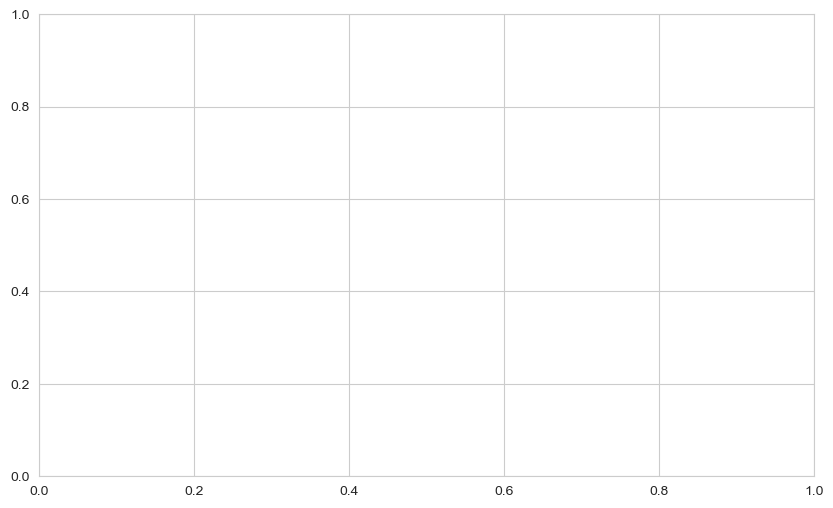

In [46]:
# 假设 array1 和 array2 是你提到的两个数组
from matplotlib import pyplot as plt
# 生成索引，用于横坐标
indices = range(1, 21)

# 创建绘图
plt.figure(figsize=(10, 6))
# plt.grid(False)
plt.grid(axis='x',which='minor')

# 绘制两个数组的值，可以选择不同的线型和标记风格来区分
plt.plot(indices, rfr_score_list, marker='o', linestyle='-', color='g', label='Random Forest',linewidth=0.6,markersize=3)
plt.plot(indices, stagen_score_list, marker='o', linestyle='-', color='b', label='StaGen-RF',linewidth=0.6,markersize=3)

# 添加图例
plt.legend()
# 添加网格

# 添加标题和轴标签
plt.title('Comparison')
plt.xlabel('Index of Experiment')
plt.ylabel('Average RMSE')
plt.xticks(range(1,21))
plt.yticks(range(2,9))
# 显示图形
plt.show()

In [42]:
print(np.mean(rfr_score_list))
print(np.mean(stagen_score_list))

print('-'*100)
print(np.std(rfr_score_list))
print(np.std(stagen_score_list))


4.6205
3.853999999999999
----------------------------------------------------------------------------------------------------
0.6546867571594831
0.7996211603003012


In [43]:

y_pred=best_model.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_score_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('random forest',rfr_score_dict)


evaluation of [ random forest ]
	- average RMSE: 2.32
	- RMSE: 
			1.95			H2
			1.96			CO
			2.00			CO2
			0.65			CH4
			0.79			Lower
			2.77			heating value
			6.16			Char yield
	- r2 score: 0.95


In [44]:
stagen=StaGen(7)
with open('trained_model/StaGen.pkl','rb') as f:
    stagen_state_dict=pickle.load(f)
stagen.load_state_dict(stagen_state_dict)
y_pred=stagen(torch.tensor(y_pred,dtype=torch.float32))
y_pred_denorm=mms_y.inverse_transform(y_pred.detach().numpy())
stagen_score_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('StaGen',stagen_score_dict)

evaluation of [ StaGen ]
	- average RMSE: 4.49
	- RMSE: 
			4.56			H2
			4.49			CO
			3.71			CO2
			1.59			CH4
			1.95			Lower
			4.03			heating value
			11.08			Char yield
	- r2 score: 0.77
